# RSA Results

### Imports

In [1]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import matplotlib as mpl
from IPython import display
import time
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from matplotlib import colors
from sklearn.decomposition import PCA

from make_models import get_MRI_VAE_3D,get_MRI_CVAE_3D
from rsa_funcs import fit_rsa,make_RDM,get_triu
import ants

### Load and Sort Data

In [2]:
data_arr = np.load('../../BC-sim/BC-sim-bigdata/synth-data-01/sim-brain-array.npz') # load compressed brain array

In [3]:
print(list(data_arr.keys())) # print data keys
data = data_arr['data'] # name data key
controls = data_arr['controls'] # name TD/control key
patients = data_arr['patients'] # name ADHD/patient key
n = data.shape[0] # shape of data
print(data.shape) # number of subjects
print(data[patients,:,:,:].shape) # print shape of patient data [number of patients, brain voxels x, brain voxels y, brain voxels z]
data_patients = data[patients,:,:,:] # name ADHD brain data
data_controls = data[controls,:,:,:] # name TD brain data

['data', 'controls', 'patients']
(1000, 64, 64, 64)
(500, 64, 64, 64)


### CVAE

In [4]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1, # controls how far away latent features can go from normal distribution, stronger beta = more nromally distributed features
                    disentangle=False, # activates the decorrelation from gamma, next time True 
                    gamma=1, # total correlation loss that penalizes for z and s features being correlated, can be increased to 100
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

### Load Weights

In [5]:
cvae.load_weights('/mmfs1/data/bergerar/BC-sim/BC-sim-bigdata/synth-data-01/sim_weights_7500_epochs') # load weights

#### Get Reconstructions

In [6]:
def get_reconstruction(data_in,adhd = True): 
    
    # reconstructs ADHD brain based on shared and specific features, reconstructs TD based on just shared features

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [7]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True) # reconstructs ADHD brains
recon_controls = get_reconstruction(data_controls,adhd = False) # reconstructs TD brains

CPU times: user 2min 19s, sys: 16.6 s, total: 2min 36s
Wall time: 3min 40s


In [8]:
recon_patients.shape # shape of reconstructed data

TensorShape([500, 64, 64, 64])

In [9]:
true_data = data_patients[0,:,:,:]
predict_data = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(true_data, predict_data).numpy()

0.00025148314

## Load Dataframe

In [10]:
df = pd.read_csv('../../BC-sim/BC-sim-bigdata/synth-data-01/sim_all_def.csv')

In [11]:
ADHDdf = df[df['DX'] != 0]
TDdf = df[df['DX'] == 0]

In [12]:
ADHDdf

,Unnamed: 0,Index,Sub,Sphere 1,Sphere 2,DX,S Deformation,Z Deformation
0,0,0,0,12.834489,10.035014,1,-2.799475,-4.043705
1,1,1,1,11.011581,11.316208,1,0.304627,-3.733940
2,2,2,2,12.606499,14.643771,1,2.037272,-4.385604
3,3,3,3,10.869074,13.482636,1,2.613562,-4.925275
4,4,4,4,6.159082,6.337349,1,0.178267,1.429249
...,...,...,...,...,...,...,...,...
495,495,495,495,7.543617,9.531810,1,1.988193,1.969164
496,496,496,496,12.901628,10.921605,1,-1.980023,-1.618177
497,497,497,497,5.062251,3.099718,1,-1.962533,-4.174104
498,498,498,498,14.173622,13.385439,1,-0.788183,4.945449


## RSA

In [13]:
symptom_vector = ADHDdf['S Deformation'].values
symptom_vector

array([-2.79947527,  0.30462664,  2.03727205,  2.61356233,  0.17826748,
        0.53419311, -1.84472201,  1.88587619, -1.83464177,  1.35466179,
        1.41844268,  1.1432855 ,  0.51621531,  1.86163145, -0.49363845,
       -1.16619127, -2.94770216,  0.31849785, -0.39681439,  1.93356615,
        2.19137355,  2.47357005,  0.29687882,  1.27066434,  2.2811094 ,
       -1.81082647,  1.85152599, -1.80656489,  1.80041686, -1.144914  ,
        0.69133178, -0.95208009,  0.62800258, -0.6267277 , -1.15082105,
       -2.93080445, -1.34884795, -2.4554004 , -0.63545854,  0.17931633,
       -1.74709229,  0.83689515,  1.61844281, -1.04462509, -1.64994255,
       -1.3633386 , -2.24991411, -0.51175007,  1.30366083, -0.96027256,
        1.03042294, -1.04385548, -1.7209793 , -0.56308292,  2.2846093 ,
        1.49202453,  0.63547176, -0.60979895, -2.63442756, -1.29527528,
        2.86975519, -0.57091531, -1.81801214,  1.51082597,  1.56599708,
        2.76505613,  2.01808388,  2.44681336, -0.26802092, -0.81

In [14]:
background_vector = TDdf['Z Deformation'].values
background_vector

array([-4.04370491, -3.73393984, -4.38560359, -4.92527523,  1.42924905,
        4.30079046,  1.52833043, -1.20376912, -1.48021589,  3.66802482,
        1.67595101,  1.7080536 ,  3.01332007, -0.75389634,  3.23490449,
        2.53740186, -3.80199293,  3.44678755,  0.75226812, -3.20970884,
        1.06338283,  1.99836141, -0.71833463, -3.07848836, -4.26125679,
        1.05738852, -0.08606152,  3.41270866,  3.68033229,  2.01875627,
       -2.97384691,  3.50763305, -4.79792747,  4.59068652,  3.49982417,
        4.15274   ,  2.74885436, -1.36128744,  3.13379344, -1.3442818 ,
        4.27292509,  4.85317037, -1.80420255, -3.05723312,  0.11966433,
       -1.7449092 , -2.79001141, -4.60025238, -2.45808939,  3.48966798,
       -2.05021488,  4.84468482,  4.87865736, -3.22108005,  0.4431636 ,
        0.36387924,  1.9438954 , -2.54386161,  1.42293397,  2.65276553,
       -1.8399532 , -2.57725644, -2.22862402, -0.55212659,  1.38246452,
        2.66920504,  2.64866073, -0.90648468, -2.10014238,  0.32

In [15]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_vector)
background = np.array(background_vector)

In [16]:
s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)
symptom_rdm = make_RDM(symptom)
background_rdm = make_RDM(background)

In [17]:
symptom_rdm.shape

(500, 500)

In [18]:
z_patients_rdm.shape

(500, 500)

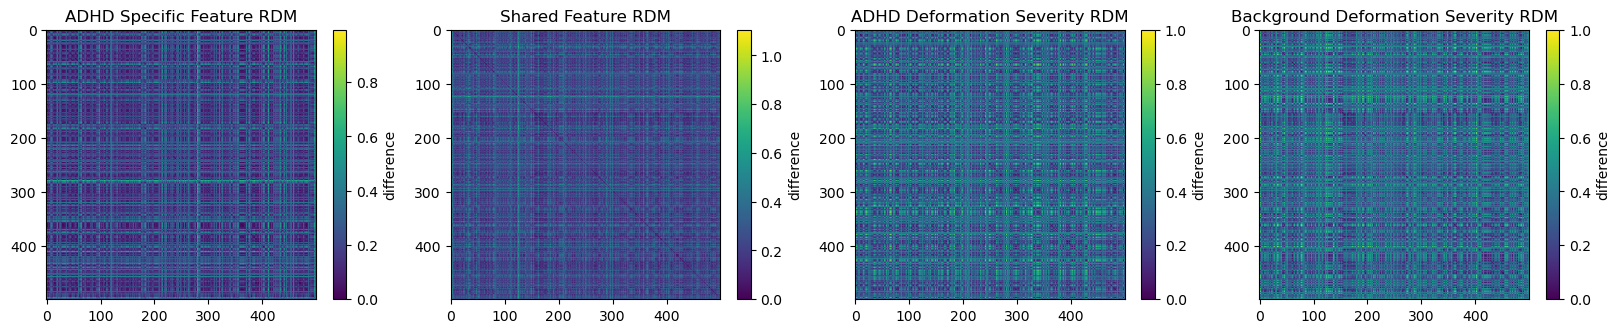

In [19]:
plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
plt.imshow(s_patients_rdm)
plt.title('ADHD Specific Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,4,2)
plt.imshow(z_patients_rdm)
plt.title('Shared Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,4,3)
plt.imshow(symptom_rdm)
plt.title('ADHD Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,4,4)
plt.imshow(background_rdm)
plt.title('Background Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.show()

#### RSA: S Deformation

In [20]:
s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
s_symptom_rsa #should be higher

0.2261202413455889

In [21]:
z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
z_symptom_rsa

0.052477556113916794

#### RSA: Z Deformation

In [22]:
s_background_rsa = fit_rsa(s_patients_rdm, background_rdm)
s_background_rsa #should b lower --> its lower woo!

0.0007841047004942936

In [23]:
z_background_rsa = fit_rsa(z_patients_rdm, background_rdm)
z_background_rsa

0.6725188054579792

## Randomized RSA loop

In [26]:
s_rand_s_rsa = [] # first letter is s or z for adhd specific or shared, second is deformation type: adhd symptom or background
s_rand_z_rsa = []
z_rand_s_rsa = []
s_rand_z_rsa = []


symptom_vector = ADHDdf['S Deformation'].values
symptom = np.array(symptom_vector)

background_vector = ADHDdf['Z Deformation'].values
background = np.array(background_vector)

s_encoder_predict = s_encoder.predict(data_patients)[0]
z_encoder_predict = z_encoder.predict(data_patients)[0]

s_encoder_rdm = make_RDM(s_encoder_predict) # make rdm of cvae's ADHD specific features
z_encoder_rdm = make_RDM(z_encoder_predict) # make rdm of cvae's background features


from sklearn.utils import shuffle

for s in range(0,1000):
    print(s)

    symptom_random = shuffle(symptom) # random order symptom deformation vector

    rand_symptom_rdm = make_RDM(symptom_random)
    
    background_random = shuffle(background) #random order background deformation vector

    rand_background_rdm = make_RDM(background_random)
    
    s_rand_symptom_rsa = fit_rsa(s_encoder_rdm, rand_symptom_rdm) # compare ADHD specific features from cvae with actual ADHD specific deformations in brains
    z_rand_symptom_rsa = fit_rsa(z_encoder_rdm, rand_symptom_rdm) # compare shared features from cvae with actual background deformations in brains
    s_rand_s_rsa.append(s_rand_symptom_rsa)
    z_rand_s_rsa.append(z_rand_symptom_rsa)
    
    s_rand_background_rsa = fit_rsa(s_encoder_rdm, rand_background_rdm) # compare 
    z_rand_background_rsa = fit_rsa(z_encoder_rdm, rand_background_rdm)
    s_rand_z_rsa.append(s_rand_background_rsa)
    z_rand_z_rsa.append(z_rand_background_rsa)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

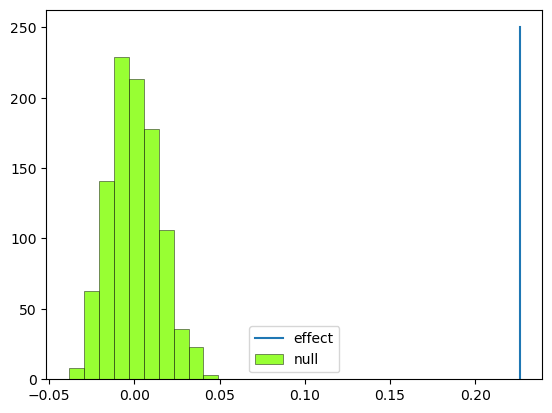

In [45]:
plt.hist(s_rand_s_rsa, alpha = 0.8, color='chartreuse', edgecolor = 'black', linewidth=0.4 )
yticks = plt.yticks()
xs = [s_symptom_rsa,s_symptom_rsa]
ys = [yticks[0].min(),yticks[0].max()]
plt.plot(xs,ys)
plt.legend(['effect','null'])
plt.show()

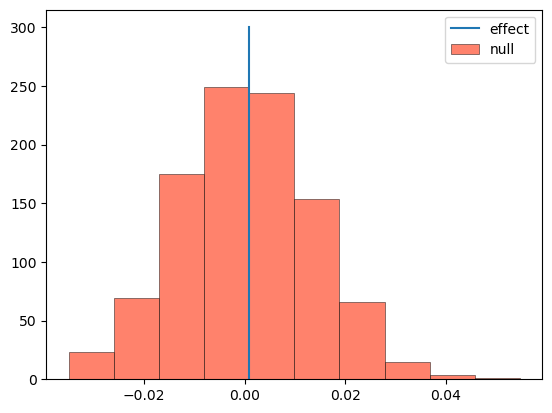

In [47]:
plt.hist(s_rand_z_rsa, alpha = 0.8, color='tomato', edgecolor = 'black', linewidth=0.4 )
yticks = plt.yticks()
xs = [s_background_rsa,s_background_rsa]
ys = [yticks[0].min(),yticks[0].max()]
plt.plot(xs,ys)
plt.legend(['effect','null'])
plt.show()

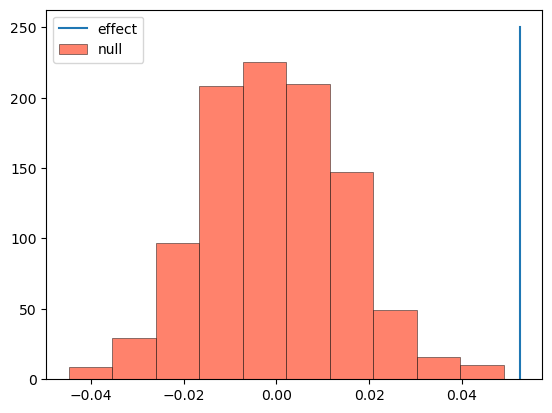

In [49]:
plt.hist(z_rand_s_rsa, alpha = 0.8, color='tomato', edgecolor = 'black', linewidth=0.4 )
yticks = plt.yticks()
xs = [z_symptom_rsa,z_symptom_rsa]
ys = [yticks[0].min(),yticks[0].max()]
plt.plot(xs,ys)
plt.legend(['effect','null'])
plt.show()

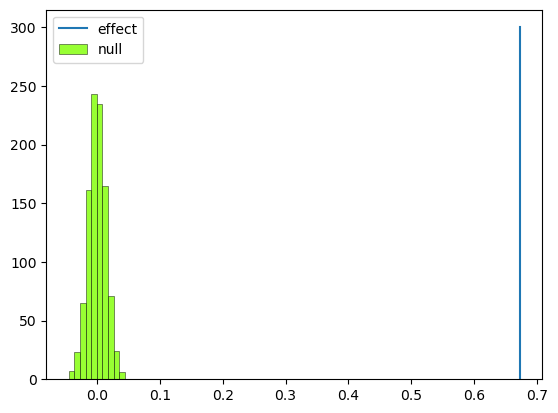

In [50]:
plt.hist(z_rand_z_rsa, alpha = 0.8, color='chartreuse', edgecolor = 'black', linewidth=0.4 )
yticks = plt.yticks()
xs = [z_background_rsa,z_background_rsa]
ys = [yticks[0].min(),yticks[0].max()]
plt.plot(xs,ys)
plt.legend(['effect','null'])
plt.show()

### Significance Results

In [27]:
count = 0
for i in s_rand_s_rsa:
    if i > s_symptom_rsa: # change names should be s_patients
        count = count + 1

In [28]:
print(count)

0


In [29]:
count/1000

0.0

In [41]:
#### this one should be higher

count2 = 0
for i in z_rand_s_rsa:
    if i > z_symptom_rsa:
        count2 = count2 + 1
        


In [42]:
print(count2)

0


In [43]:
count2/1000

0.0

In [33]:
print(s_symptom_rsa)
print(z_symptom_rsa)

0.2261202413455889
0.052477556113916794


In [34]:
count3 = 0
for i in s_rand_z_rsa:
    if i > s_background_rsa:
        count3 = count3 + 1

In [35]:
print(count3)

485


In [36]:
count3/1000

0.485

In [37]:
count4 = 0
for i in z_rand_z_rsa:
    if i > z_background_rsa:
        count4 = count4 + 1

In [38]:
print(count4)

0


In [39]:
count4/1000

0.0

In [40]:
print(s_background_rsa)
print(z_background_rsa)

0.0007841047004942936
0.6725188054579792
